In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [3]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [4]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [5]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')
print(train.shape, test.shape)

(2577, 34) (936, 33)


## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수, 분양세대수

In [6]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 39) (936, 38)


# 연면적

- 모르겠따...

# 자격유형

In [20]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [21]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [22]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [23]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [24]:
train.shape, test.shape

((2577, 39), (936, 38))

# 어제 결과를 보니까 1차원으로 해야 할 것 같다.

In [25]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '분양세대수', '자격유형_카테고리'],
      dtype='object')

In [26]:
len(set(train.단지코드))

414

In [27]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [28]:
data.shape

(414, 31)

In [29]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()

In [30]:
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,566
1,C1004,영구임대,504
2,C1004,임대상가,13
3,C1005,국민임대,1144
4,C1013,국민임대,1308


In [31]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [32]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [33]:
train_a=train[train.임대건물구분=="아파트"]
test_a=test[test.임대건물구분=="아파트"]

In [34]:
sample = train_a.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,104695.000000,4.705000e+06
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [35]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [36]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [37]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [38]:
data=data.fillna(0)

In [39]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [40]:
data=pd.merge(data, sample, on="단지코드", how="inner")

In [41]:
sample1=pd.DataFrame(train_a.groupby("단지코드")["전용면적"].mean()).reset_index()
sample2=pd.DataFrame(train_a.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,1,2,7,3,6,4,5,대형전용면적,전용면적,전용면적별세대수
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,545.0,0.0,0.0,0.0,0.0,0.0,0.0,0,44.345714,77.857143
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,914.0,0.0,0.0,0.0,0.0,0.0,0.0,0,39.326250,114.250000
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.0,0.0,0.0,635.0,0.0,0.0,0.0,0,52.668000,127.000000
3,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,...,696.0,0.0,0.0,0.0,0.0,0.0,0.0,0,42.982500,174.000000
4,C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,...,566.0,0.0,0.0,0.0,0.0,0.0,0.0,0,42.575000,94.333333


In [42]:
sample1=pd.DataFrame(train_a.groupby("단지코드")["임대료"].std()).reset_index()
sample2=pd.DataFrame(train_a.groupby("단지코드")["임대보증금"].std()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,7,3,6,4,5,대형전용면적,전용면적,전용면적별세대수,임대료_y,임대보증금_y
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,0.0,0.0,0.0,0.0,0.0,0,44.345714,77.857143,42079.044553,5.398382e+06
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,0.0,0.0,0.0,0.0,0.0,0,39.326250,114.250000,43403.524194,9.928516e+06
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.0,635.0,0.0,0.0,0.0,0,52.668000,127.000000,47045.761021,5.616362e+06
3,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,...,0.0,0.0,0.0,0.0,0.0,0,42.982500,174.000000,21378.507899,6.753065e+06
4,C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,...,0.0,0.0,0.0,0.0,0.0,0,42.575000,94.333333,19152.348594,6.067941e+06


In [43]:
sample1=pd.DataFrame(train_a.groupby("단지코드")["전용면적"].std()).reset_index()
sample2=pd.DataFrame(train_a.groupby("단지코드")["전용면적별세대수"].std()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head(3)

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,6,4,5,대형전용면적,전용면적_x,전용면적별세대수_x,임대료_y,임대보증금_y,전용면적_y,전용면적별세대수_y
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,0.0,0.0,0.0,0,44.345714,77.857143,42079.044553,5.398382e+06,6.981112,92.611066
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,0.0,0.0,0.0,0,39.326250,114.250000,43403.524194,9.928516e+06,7.681880,83.941731
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.0,0.0,0.0,0,52.668000,127.000000,47045.761021,5.616362e+06,8.257813,59.422218


# Test에 똑같이

In [44]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 30)

In [45]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [46]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [47]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [48]:
sample = test_a.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,115875.000000,2.265000e+07
1,C1006,95811.666667,6.932500e+06
2,C1016,228010.000000,2.402675e+07
3,C1019,126430.000000,1.485750e+07
4,C1030,214216.666667,5.141333e+07


In [49]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [50]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [51]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [52]:
dat=dat.fillna(0)

In [53]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [54]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [55]:
sample1=pd.DataFrame(test_a.groupby("단지코드")["전용면적"].mean()).reset_index()
sample2=pd.DataFrame(test_a.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
dat=pd.merge(dat, sample2, on="단지코드", how="inner")

sample1=pd.DataFrame(test_a.groupby("단지코드")["임대료"].std()).reset_index()
sample2=pd.DataFrame(test_a.groupby("단지코드")["임대보증금"].std()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
dat=pd.merge(dat, sample2, on="단지코드", how="inner")

sample1=pd.DataFrame(test_a.groupby("단지코드")["전용면적"].std()).reset_index()
sample2=pd.DataFrame(test_a.groupby("단지코드")["전용면적별세대수"].std()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
dat=pd.merge(dat, sample2, on="단지코드", how="inner")
dat.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,단지명,도로명주소,연면적,...,6,3,5,대형전용면적,전용면적_x,전용면적별세대수_x,임대료_y,임대보증금_y,전용면적_y,전용면적별세대수_y
0,C1072,754,경기도,14,0.0,2,683,광명역세권 휴먼시아2단지,경기도 광명시 서원로 25,13.320,...,0.0,724.0,0.0,0,48.436250,94.250000,38479.156858,7.194365e+06,4.256366,53.625021
1,C1128,1354,경기도,9,0.0,3,1216,광명역세권 휴먼시아1단지,경기도 광명시 성채안로 26,3773.770,...,0.0,1132.0,0.0,0,46.178889,150.444444,46424.527731,9.064546e+06,5.259844,148.002628
2,C1456,619,부산광역시,18,0.0,16,547,안락휴먼시아,부산광역시 동래구 충렬대로447번길 38,6035.780,...,0.0,0.0,0.0,0,44.771250,66.625000,49650.253344,1.147678e+07,8.432601,43.457492
3,C1840,593,전라북도,7,0.0,3,543,장신휴먼시아3단지,전라북도 익산시 오산면 선화로4길 14,6006.870,...,0.0,0.0,0.0,0,44.492500,148.250000,18024.444513,5.407500e+06,6.043577,81.960865
4,C1332,1297,경기도,11,0.0,2,1112,봇들마을 6단지,경기도 성남시 분당구 동판교로 212,361.789,...,0.0,1297.0,0.0,0,46.453750,162.125000,61330.117980,8.676170e+06,4.543887,69.800609


In [56]:
data=data.fillna(0)

In [57]:
dat.columns

Index([       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',       '분양세대수',        '행복주택',        '영구임대',
              '임대상가',        '국민임대',   '공공임대(50년)',    '공공임대(단기)',
          '공공임대(분납)',       '임대료_x',     '임대보증금_x',             4,
                   2,             7,             1,             6,
                   3,             5,      '대형전용면적',      '전용면적_x',
        '전용면적별세대수_x',       '임대료_y',     '임대보증금_y',      '전용면적_y',
        '전용면적별세대수_y'],
      dtype='object')

In [58]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name',    'subway_dist',    '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',       '분양세대수',    '행복주택',        '영구임대',
              '임대상가',        '국민임대',   '공공임대(50년)',    '공공임대(단기)',
          '공공임대(분납)',       '임대료_mean',     '임대보증금_mean',            '자격유형4',
                   '자격유형2',          '자격유형7',  '자격유형1'  ,             '자격유형6',
                   '자격유형3',           '자격유형5' ,      '대형전용면적',      '전용면적_mean',
        '전용면적별세대수_mean',       '임대료_std',     '임대보증금_std',      '전용면적_std',
        '전용면적별세대수_std']

In [59]:
data.columns

Index([       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',       '분양세대수',        '국민임대',
              '영구임대',        '임대상가',    '공공임대(단기)',        '장기전세',
              '행복주택',    '공공임대(분납)',        '공공분양',   '공공임대(50년)',
             '임대료_x',     '임대보증금_x',             1,             2,
                   7,             3,             6,             4,
                   5,      '대형전용면적',      '전용면적_x',  '전용면적별세대수_x',
             '임대료_y',     '임대보증금_y',      '전용면적_y',  '전용면적별세대수_y'],
      dtype='object')

In [60]:
data.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name',  'subway_dist', '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',       '분양세대수',   '국민임대',
              '영구임대',        '임대상가',    '공공임대(단기)',        '장기전세',
              '행복주택',    '공공임대(분납)',        '공공분양',   '공공임대(50년)',
             '임대료_mean',     '임대보증금_mean',       '자격유형1',   '자격유형2',
               '자격유형7' ,          '자격유형3' ,       '자격유형6' ,        '자격유형4' ,
                  '자격유형5' ,      '대형전용면적',      '전용면적_mean',  '전용면적별세대수_mean',
             '임대료_std',     '임대보증금_std',      '전용면적_std',  '전용면적별세대수_std']

# Correlation 확인

In [61]:
X_cor = data.drop(columns=['단지코드','단지명','도로명주소','subway_name', "지역", 
                          "자격유형1", "자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"])

In [62]:
X_cor = pd.get_dummies(X_cor, drop_first=True)

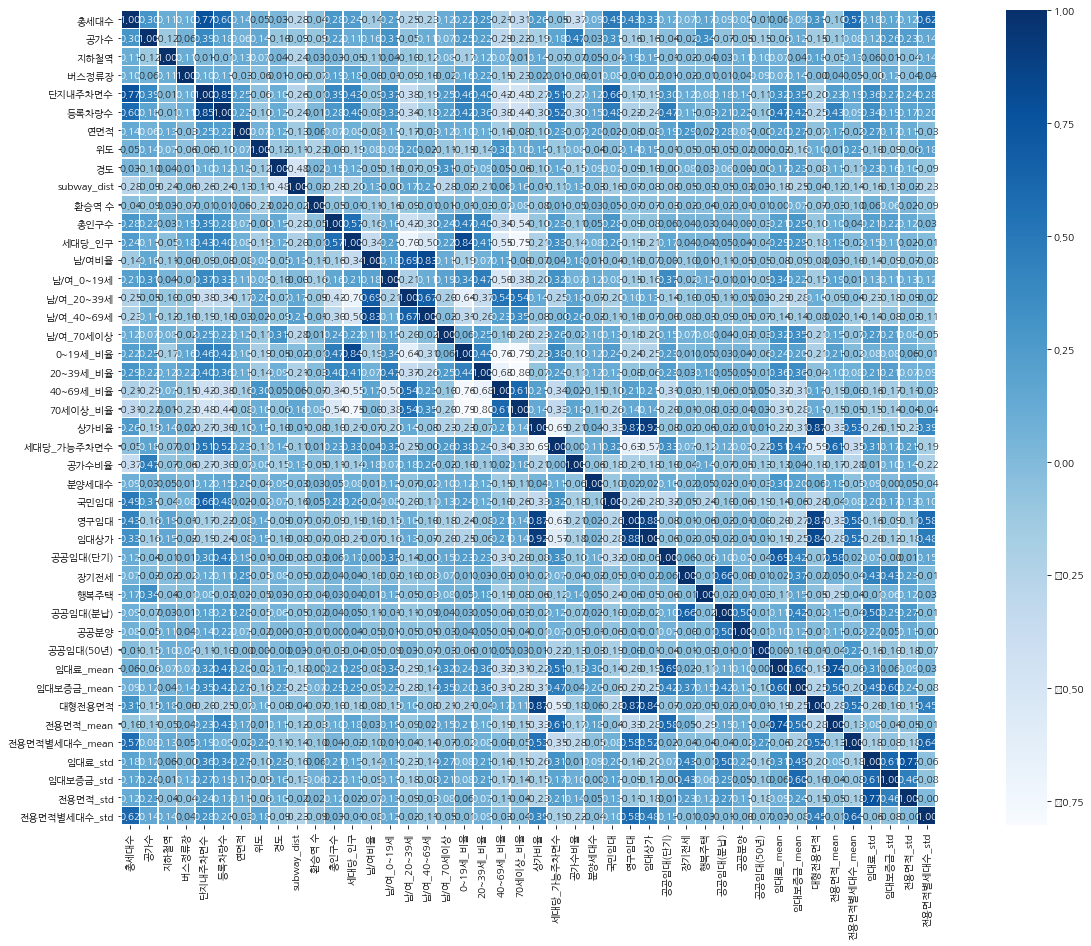

In [63]:
plt.subplots(figsize=(25,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

### correlation 너무 높은 변수: 
- 영구임대&자격유형2 
- 임대상가&상가비율<br>

# Modeling

In [64]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

## 기본으로 돌려보기

In [65]:
X = data.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
y = data[['등록차량수']]

In [66]:
X = pd.get_dummies(X, drop_first=True)

In [67]:
len(X.columns)

65

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [69]:
lr= LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_absolute_error(y_test, lr_pred)

128.43606601288823

In [70]:
ri = Ridge().fit(X_train, y_train)
ri_pred = ri.predict(X_test)
mean_absolute_error(y_test, ri_pred)

122.70804123607121

In [71]:
la = Lasso().fit(X_train, y_train)
la_pred = la.predict(X_test)
mean_absolute_error(y_test, la_pred)

120.85481486976

In [72]:
rf = RandomForestRegressor(random_state=2021, criterion="mae").fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mean_absolute_error(y_test, rf_pred)

115.71104000000001

In [73]:
cb = CatBoostRegressor(random_state=2021, verbose=False ).fit(X_train, y_train)
cb_pred = cb.predict(X_test)
mean_absolute_error(y_test, cb_pred)

112.32706702518384

In [74]:
xgb = XGBRegressor(random_state=2021).fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
mean_absolute_error(y_test, xgb_pred)

122.93197338867188

In [75]:
en=ElasticNet(random_state=2021).fit(X_train, y_train)
en_pred = en.predict(X_test)
mean_absolute_error(y_test, en_pred)

118.59609919543372

Text(0.5, 0, 'CatBoost Feature Importance')

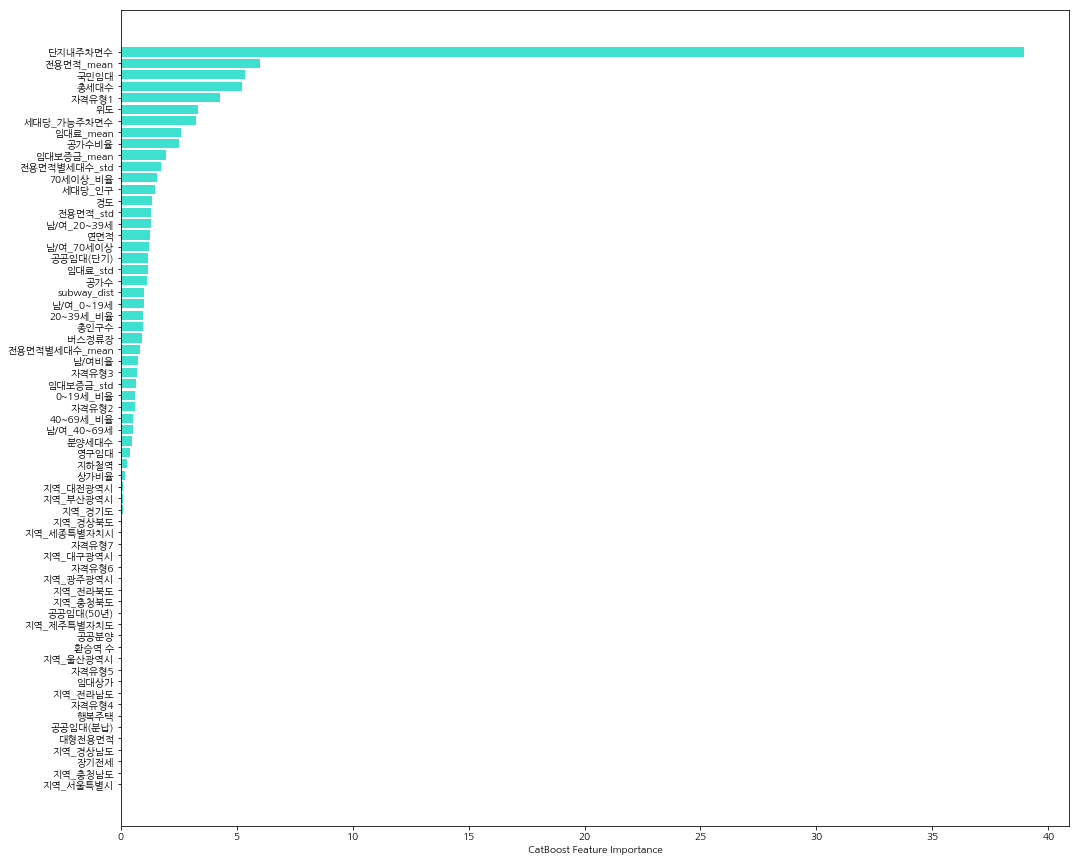

In [76]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = cb.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
        cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# 하나로 예측

In [77]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [78]:
# sample = sample.loc[~sample.code.isin(['C2335', 'C1327', 'C2675'])]

In [79]:
sample.shape

(150, 2)

In [130]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [131]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 56) (104, 56)
(113, 53) (34, 53)


In [132]:
df= pd.concat([train1, test1])

In [133]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
X = pd.get_dummies(X, drop_first=True)

In [134]:
X.train=X.iloc[0:310, :]
X.test=X.iloc[310:, :]
y_train = train1[['등록차량수']]

In [135]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [136]:
model_1=CatBoostRegressor(random_state=2021, verbose=False).fit(X.train, y_train)
model1_pred = model_1.predict(X.test)

In [137]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [138]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1.head()

,code,num
0,C1072,686.646247
1,C1456,537.737809
2,C1840,528.515955
3,C1640,453.332168
4,C1377,305.627356


In [139]:
df= pd.concat([train2, test2])

In [140]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
X = pd.get_dummies(X, drop_first=True)

In [141]:
X.train=X.iloc[0:104, :]
X.test=X.iloc[104:, :]
y_train = train2[['등록차량수']]

In [142]:
model_2=CatBoostRegressor(random_state=2021, verbose=False).fit(X.train, y_train)
model2_pred = model_2.predict(X.test)

In [143]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [144]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
pred2.head()

,code,num
0,C1128,1180.223927
1,C1332,1200.937017
2,C1563,1660.644305
3,C1794,913.717682
4,C2411,746.364606


In [145]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [146]:
df_merge.head()

,code,num
0,C1072,686.646247
1,C1456,537.737809
2,C1840,528.515955
3,C1640,453.332168
4,C1377,305.627356


In [148]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [149]:
test_split.head()

,code,num_x,num_y
0,C1072,0,686.646247
1,C1128,0,1180.223927
2,C1456,0,537.737809
3,C1840,0,528.515955
4,C1332,0,1200.937017


In [150]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [151]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [92]:
from catboost import Pool

In [94]:
sorted_feature_importance = model_1.feature_importances_.argsort()

In [95]:
sorted_feature_importance

array([57, 29,  9, 63, 21, 31, 30, 42, 60, 59, 62, 61, 32, 33, 50, 43, 51,
       64, 40, 58, 56, 55, 41, 26, 54, 52, 27, 53, 37, 38, 24,  2, 15, 47,
       39, 19, 11, 13, 18, 12,  5,  7,  8, 14, 17,  3, 20, 16, 46,  6,  1,
       48, 10, 28, 45, 49, 35, 34, 22, 23, 25, 36,  0, 44,  4],
      dtype=int64)

In [96]:
X.test.columns[sorted_feature_importance]

Index(['지역_서울특별시', '장기전세', '환승역 수', '지역_충청남도', '상가비율', '공공임대(분납)', '행복주택',
       '자격유형5', '지역_전라남도', '지역_울산광역시', '지역_제주특별자치도', '지역_전라북도', '공공분양',
       '공공임대(50년)', '지역_경기도', '대형전용면적', '지역_경상남도', '지역_충청북도', '자격유형6',
       '지역_세종특별자치시', '지역_부산광역시', '지역_대전광역시', '자격유형4', '영구임대', '지역_대구광역시',
       '지역_경상북도', '임대상가', '지역_광주광역시', '자격유형2', '자격유형7', '분양세대수', '지하철역',
       '남/여_40~69세', '임대보증금_std', '자격유형3', '40~69세_비율', '세대당_인구', '남/여_0~19세',
       '20~39세_비율', '남/여비율', '연면적', '경도', 'subway_dist', '남/여_20~39세',
       '0~19세_비율', '버스정류장', '70세이상_비율', '남/여_70세이상', '임대료_std', '위도', '공가수',
       '전용면적_std', '총인구수', '공공임대(단기)', '전용면적별세대수_mean', '전용면적별세대수_std',
       '임대보증금_mean', '임대료_mean', '세대당_가능주차면수', '공가수비율', '국민임대', '자격유형1',
       '총세대수', '전용면적_mean', '단지내주차면수'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

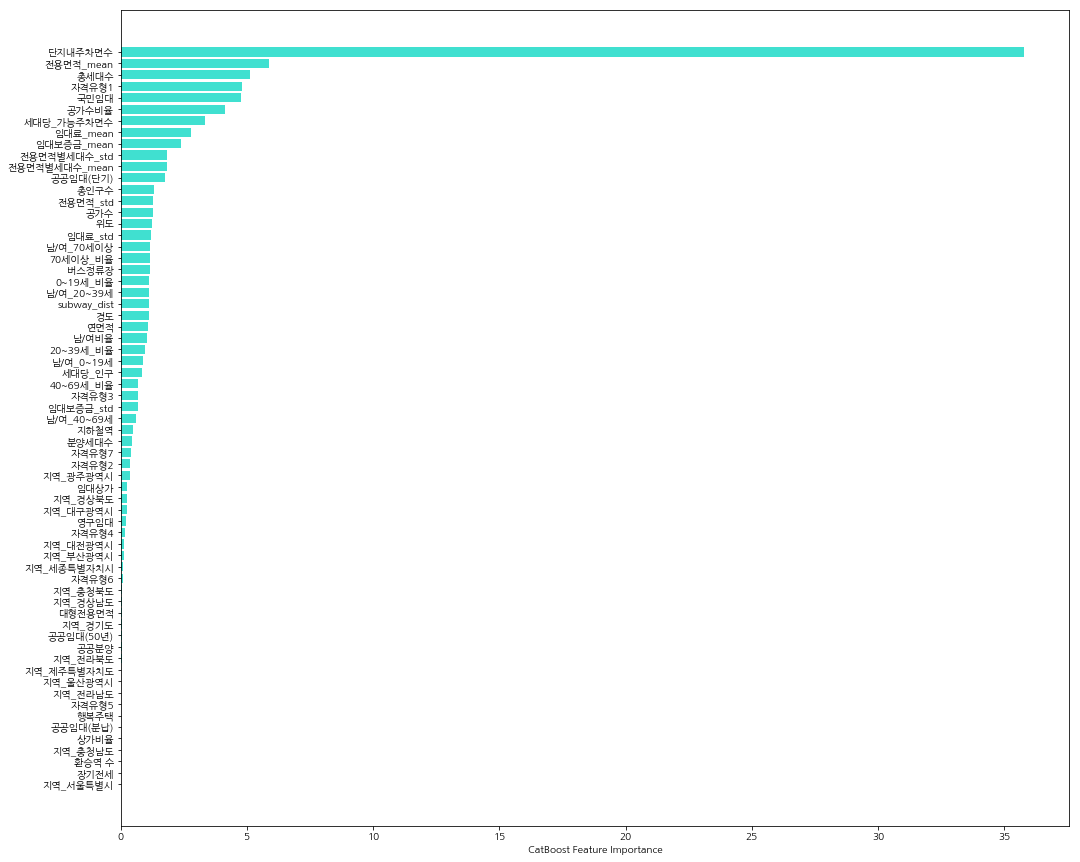

In [98]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_1.feature_importances_.argsort()
plt.barh(X.test.columns[sorted_feature_importance], 
        model_1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [152]:
test_split.to_csv('0715_cb.csv', index=False)